# Random forest

## Data preprocessing steps

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly

In [86]:
# loading the transformed data

train = pd.read_csv('data/train_transformed.csv').reset_index(drop=True)
validation = pd.read_csv('data/validation_transformed.csv')

train = train.drop(columns='Unnamed: 0')
validation = validation.drop(columns='Unnamed: 0')

In [95]:
train.columns

Index(['Sales', 'CompetitionDistance', 'Store_cat', 'CompetitionSinceMonths',
       'Promo2SinceWeeks', 'Promo_0.0', 'Promo_1.0', 'StateHoliday_0',
       'StateHoliday_Christmas', 'StateHoliday_Easter', 'StateHoliday_Public',
       'SchoolHoliday_0.0', 'SchoolHoliday_1.0', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'Month_1', 'Month_10', 'Month_11', 'Month_12',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6'],
      dtype='object')

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422591 entries, 0 to 422590
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Sales                   422591 non-null  float64
 1   CompetitionDistance     422591 non-null  float64
 2   Store_cat               422591 non-null  float64
 3   CompetitionSinceMonths  422591 non-null  float64
 4   Promo2SinceWeeks        422591 non-null  float64
 5   Promo_0.0               422591 non-null  int64  
 6   Promo_1.0               422591 non-null  int64  
 7   StateHoliday_0          422591 non-null  int64  
 8   StateHoliday_Christmas  422591 non-null  int64  
 9   StateHoliday_Easter     422591 non-null  int64  
 10  StateHoliday_Public     422591 non-null  int64  
 11  SchoolHoliday_0.0       422591 non-null  int64  
 12  SchoolHoliday_1.0       422591 non-null  int64  
 13  StoreType_a             422591 non-null  int64  
 14  StoreType_b         

In [92]:
# types in the columns

train.dtypes

Sales                     float64
CompetitionDistance       float64
Store_cat                 float64
CompetitionSinceMonths    float64
Promo2SinceWeeks          float64
Promo_0.0                   int64
Promo_1.0                   int64
StateHoliday_0              int64
StateHoliday_Christmas      int64
StateHoliday_Easter         int64
StateHoliday_Public         int64
SchoolHoliday_0.0           int64
SchoolHoliday_1.0           int64
StoreType_a                 int64
StoreType_b                 int64
StoreType_c                 int64
StoreType_d                 int64
Assortment_a                int64
Assortment_b                int64
Assortment_c                int64
Month_1                     int64
Month_10                    int64
Month_11                    int64
Month_12                    int64
Month_2                     int64
Month_3                     int64
Month_4                     int64
Month_5                     int64
Month_6                     int64
Month_7       

In [90]:
ytrain = train['Sales']
Xtrain = train.drop(columns = 'Sales')

yval = validation['Sales']
Xval = validation.drop(columns = 'Sales')

## Run Random Forest with all features for base line and check feature importance

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [57]:
# metric 

def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [91]:
# base line Random Forest with default parameters

base_rf = RandomForestRegressor(random_state=42)
base_rf.fit(Xtrain, ytrain)

pred_train = base_rf.predict(Xtrain)
pred_val = base_rf.predict(Xval)

base_train = metric(np.array(pred_train), np.array(ytrain))

base_val = metric(np.array(pred_val), np.array(yval))

In [93]:
print(f'RMSPE train {base_train}')
print(f'RMSPE val {base_val}')

RMSPE train 16.73220941031702
RMSPE val 28.606579538106395


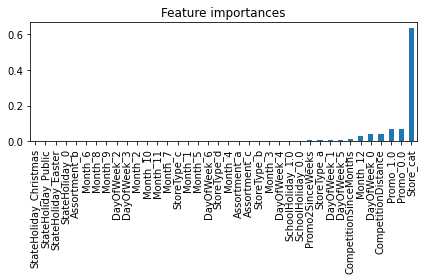

In [94]:
# feature importance 
importances = base_rf.feature_importances_

forest_importances = pd.Series(importances, index=Xtrain.columns)
std = np.std([base_rf.feature_importances_ for tree in base_rf.estimators_], axis=0)
forest_importances = forest_importances.sort_values()

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

## About features: missing week of the year?
### From previous the base, remove features with less important and try again

In [97]:
rem_col = {
  'rem_promo': ['Promo_0.0', 'Promo_1.0'],
  'rem_holidays': ['StateHoliday_0', 'StateHoliday_Christmas', 'StateHoliday_Easter', 'StateHoliday_Public',
                  'SchoolHoliday_0.0', 'SchoolHoliday_1.0'],
  'rem_assortment_holidays': ['StateHoliday_0', 'StateHoliday_Christmas', 'StateHoliday_Easter', 'StateHoliday_Public',
                  'SchoolHoliday_0.0', 'SchoolHoliday_1.0','Assortment_a', 'Assortment_b', 'Assortment_c']  
}

In [98]:
list(rem_col.keys())

['rem_promo', 'rem_holidays', 'rem_assortment_holidays']

In [52]:
# Testing performance removing different set of features

In [99]:
metrics_all = []
dd = list(rem_col.keys()) 

for i in range(len(rem_col)):
    model = RandomForestRegressor(random_state=42)
    model.fit(Xtrain.drop(columns=rem_col[dd[i]]), ytrain)

    pred_train_new = model.predict(Xtrain.drop(columns=rem_col[dd[i]]))
    pred_val_new = model.predict(Xval.drop(columns=rem_col[dd[i]]))

    metrics_all.append(metric(np.array(pred_val_new), np.array(yval)))
    
    

In [100]:
# Metrics for different features combinations

for i in range(len(rem_col)):
    print(f'RMSPE for {dd[i]} is {metrics_all[i]}')


RMSPE for rem_promo is 36.69922933211894
RMSPE for rem_holidays is 25.331353987048967
RMSPE for rem_assortment_holidays is 25.192994421751838


### Partial result, remove columns: [rem_assortment_holidays]

In [84]:
# Grid for random search over selected feature combination

best_index = 2

n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=4)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 50, num=5)]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}


model_RFR = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=model_RFR,
                               param_distributions=grid,
                               n_iter=5,  # try 5 models
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(Xtrain.drop(columns=rem_col[dd[best_index]]), ytrain)
best_random = rf_random.best_estimator_
print(f'Best model is {best_random}')
best_metric = metric(np.array(best_random.predict(Xval.drop(columns=rem_col[dd[best_index]]))), np.array(yval))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best model is RandomForestRegressor(max_depth=38, max_features='sqrt', n_estimators=130)


In [ ]:
# Grid search over selected feature combination
best_index = 2

n_estimators = [int(x) for x in np.linspace(start=10, stop=80, num=4)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num=5)]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}


model_RFR = RandomForestRegressor()
rf_random = GridSearchCV(estimator=model_RFR,
                               param_grid=grid,
                               cv=3,
                               verbose=0,
                               n_jobs=-1)

rf_random.fit(Xtrain.drop(columns=rem_col[dd[best_index]]), ytrain)
best_random = rf_random.best_estimator_
print(f'Best model is {best_random}')
best_metric = metric(np.array(best_random.predict(Xval.drop(columns=rem_col[dd[best_index]]))), np.array(yval))


In [85]:
# the metric is almost the same as with the default parameters
print(f'Metric with best forest is {best_metric}')

Metric with best forest is 23.577647791245695


In [ ]:
# Saving the best model obtained with Random Forest

import cPickle

with open('saved_models', 'wb') as f:
    cPickle.dump(rf, f)

In [ ]:
# Loading the model

